# Libs

In [213]:
#Activate Gurobi environment

import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm

import multiprocessing as mp
from functools import partial
from multiprocessing import Pool
import timeit
from pyomo.environ import *
import math
import sys


PathData="./Data/"

In [222]:
#Using time series of flood as as synthetic flood scenario
Data=np.load(PathData+"DJKFlorence.npz",allow_pickle=True)
TimeDiscretizations=Data["TimeDiscretizations"]
D=np.load(PathData+"OD.npz")
OD=D["OD"]
DJKs_Road_V0=Data["DJKs_Road_Flood"].item()


StartNode_Idx=5738
EndNode_Idx=5190
alpha=0.9
Max_ETT=9999999

In [215]:
Data=np.load(PathData+"DJKFlorence.npz",allow_pickle=True)
DJKs_Road_V0=Data["DJKs_Road_Flood"].item()
Arc_Travel_Time  =DJKs_Road_V0["Arc_Travel_Time"]
Arc_Idx          =DJKs_Road_V0["Arc_Idx"]

TT_T0=np.sum(Arc_Travel_Time,axis=1)
TT_T0=(np.sum(Arc_Travel_Time,axis=1)!=np.inf)
Arc_Idx_Idx=Arc_Idx[TT_T0]
Node_Idx=list(np.unique(Arc_Idx_Idx))


# Optimization model

In [216]:
def Stochastic_Time_Dependent_Dijkstra(StartNode_Idx, EndNode_Idx, DJKs_Road_V0, Max_ETT=10**9, alpha=0.9):

  Node_ID          =DJKs_Road_V0["Node_ID"]

  StartNode_ID     =Node_ID[StartNode_Idx]
  EndNode_ID       =Node_ID[EndNode_Idx]

  Arc_ID           =DJKs_Road_V0["Arc_ID"]
  Arc_Idx          =DJKs_Road_V0["Arc_Idx"]

  #Using each hour of the time series as a possible scenario
  Arc_Travel_Time  =DJKs_Road_V0["Arc_Travel_Time"]
  TT_T0=np.sum(Arc_Travel_Time,axis=1)

  NScenarios=Arc_Travel_Time.shape[1]
  TT_T0=(np.sum(Arc_Travel_Time,axis=1)!=np.inf)
  Arc_Travel_Time=Arc_Travel_Time[TT_T0,:]
  Arc_ID=Arc_ID[TT_T0]
  Arc_Idx_Idx=Arc_Idx[TT_T0]
  Node_Idx=list(np.unique(Arc_Idx_Idx))

  Arc_Length       =DJKs_Road_V0["Arc_Length"]
  Idx_ArcsWith_i   =DJKs_Road_V0["Idx_ArcsWith_i"]

  ##
  ArcInForEachNode=[] #ArcInForEachNode
  ArcOutForEachNode=[] #ArcOutForEachNode

  count=0
  for i in Node_Idx:
      ArcInForEachNode.append(np.where(Arc_Idx_Idx[:,0]==i)[0])
      ArcOutForEachNode.append(np.where(Arc_Idx_Idx[:,1]==i)[0])

      if i==StartNode_Idx:
          StartNode_Idx_Idx=count
      if i==EndNode_Idx:
          EndNode_Idx_Idx=count

      count=count+1

  ArcZero=list(np.arange(len(Node_Idx)))
  ArcZero.remove(StartNode_Idx_Idx)
  ArcZero.remove(EndNode_Idx_Idx)

  ###### Set
  Model = ConcreteModel()
  Model.NumNodes= Set(initialize=Node_Idx)# Set of Nodes
  Model.ArcIdx = RangeSet(0,Arc_Idx_Idx.shape[0]-1)# Set of all arcs

  #### Variables
  Model.x =  Var(range(Arc_Idx_Idx.shape[0]), domain=Binary)#
  Model.c = Var(domain=NonNegativeReals)
  Model.z = Var(range(NScenarios),domain=NonNegativeReals)

  MeanETT=np.mean(Arc_Travel_Time,axis=1) # For each arc

  def objective_rule(Model):   

      ETT=summation(MeanETT,Model.x)
      CVaR=Model.c+1/((1-alpha)*NScenarios)*sum(Model.z[i] for i in range(NScenarios))
      Output=CVaR 

      return Output

  def CVaRZ(Model,i):
      return Model.z[i]>=summation(Arc_Travel_Time[:,i], Model.x)-Model.c

  Model.CVaRZ = Constraint(range(NScenarios), rule=CVaRZ)

  def FlowZero(Model,i):
      return (sum(-Model.x[arc] for arc in ArcOutForEachNode[i])+sum(Model.x[arc] for arc in ArcInForEachNode[i]))==0

  Model.FlowZero = Constraint(ArcZero, rule=FlowZero)

  Model.PositiveFlow = Constraint(expr=-sum(Model.x[arc] for arc in ArcOutForEachNode[StartNode_Idx_Idx])+sum(Model.x[arc] for arc in ArcInForEachNode[StartNode_Idx_Idx])==1)
  Model.NegativeFlow = Constraint(expr=-sum(Model.x[arc] for arc in ArcOutForEachNode[EndNode_Idx_Idx])+sum(Model.x[arc] for arc in ArcInForEachNode[EndNode_Idx_Idx])==-1)

  Model.MaxETT = Constraint(expr=summation(MeanETT,Model.x)<=Max_ETT)

  Model.OBJ = Objective(rule = objective_rule, sense=minimize)
  opt = SolverFactory("gurobi", solver_io="python")
  opt.options['max_iter'] = 5000
  results=opt.solve(Model, tee=True)
  Optimal_X=Model.x.get_values()
  Optimal_X=np.array([Optimal_X[i] for i in range(len(Arc_Idx_Idx))],dtype=int)
  IdxArcIn=np.where(Optimal_X)[0]
  ArcIdxUsed=Arc_Idx_Idx[IdxArcIn]
  Model.del_component(Model.MaxETT)  

  return ArcIdxUsed, Model, Arc_Idx_Idx, MeanETT

def PyomoChangeETT (Model, MeanETT, Max_ETT, Arc_Idx_Idx):

    Model.MaxETT = Constraint(expr=summation(MeanETT, Model.x)<=Max_ETT)
    opt = SolverFactory("gurobi", solver_io="python")
    opt.options['max_iter'] = 5000
    results=opt.solve(Model, tee=True)
    Optimal_X=Model.x.get_values()
    Optimal_X=np.array([Optimal_X[i] for i in range(len(Arc_Idx_Idx))],dtype=int)
    IdxArcIn=np.where(Optimal_X)[0]
    ArcIdxUsed=Arc_Idx_Idx[IdxArcIn]
    Model.del_component(Model.MaxETT)  
    return ArcIdxUsed, Model, Arc_Idx_Idx


def Compute_TravelTimes(ArcIdxUsed, DJKs_Road_V0, alpha):

  Arc_Travel_Time  =DJKs_Road_V0["Arc_Travel_Time"]
  TT_s=np.sum(Arc_Travel_Time[ArcIdxUsed,:],axis=0)

  NumScenarios=TT_s.shape[0]


  CutInt=np.maximum(int(math.ceil(NumScenarios*(1-alpha))),1)

  Expected_TT=np.mean(TT_s)
  CVaR=np.mean(np.sort(TT_s)[-CutInt:]) 

  return Expected_TT, CVaR


def GetGlobalOptimaRoute_Pyomo(ArcIdxUsed, StartNode_Idx, EndNode_Idx,  DJKs_Road_V0, alpha):
  Node_ID          =DJKs_Road_V0["Node_ID"]
  NodesIdx_In=ArcIdxUsed
  Route_idx=[]
  Route_idx.append(StartNode_Idx)
  CurrentNode=StartNode_Idx
  for i in range(len(NodesIdx_In)):
    
    Route_idx.append(NodesIdx_In[NodesIdx_In[:,0]==CurrentNode,1][0])
    CurrentNode=NodesIdx_In[NodesIdx_In[:,0]==CurrentNode,1][0]
    
  ArcIdxUsed=[np.where((ArcIdxUsed[i,0]==DJKs_Road_V0["Arc_Idx"][:,0]) * (ArcIdxUsed[i,1]==DJKs_Road_V0["Arc_Idx"][:,1]))[0][0] for i in range(len(ArcIdxUsed))]

  Route=Node_ID[Route_idx] #Convert of OpenSmap IDs
  ETT,CVaR=Compute_TravelTimes(ArcIdxUsed, DJKs_Road_V0, alpha)

  return Route, Route_idx,ETT,CVaR

In [217]:
def MinETT_Dijkstra(StartNode_Idx, EndNode_Idx, DJKs_Road_V0):

  Node_ID          =DJKs_Road_V0["Node_ID"]

  StartNode_ID     =Node_ID[StartNode_Idx]
  EndNode_ID       =Node_ID[EndNode_Idx]

    
  Arc_ID           =DJKs_Road_V0["Arc_ID"]
  Arc_Idx          =DJKs_Road_V0["Arc_Idx"]

  #Using each hour of the time series as a possible scenario
  Arc_Travel_Time  =DJKs_Road_V0["Arc_Travel_Time"]
  TT_T0=np.sum(Arc_Travel_Time,axis=1)

  NScenarios=Arc_Travel_Time.shape[1]
  TT_T0=(np.sum(Arc_Travel_Time,axis=1)!=np.inf)
  Arc_Travel_Time=Arc_Travel_Time[TT_T0,:]
  Arc_ID=Arc_ID[TT_T0]
  Arc_Idx_Idx=Arc_Idx[TT_T0]
  Node_Idx=list(np.unique(Arc_Idx_Idx))

  Arc_Length       =DJKs_Road_V0["Arc_Length"]
  Idx_ArcsWith_i   =DJKs_Road_V0["Idx_ArcsWith_i"]

  ##
  ArcInForEachNode=[] #ArcInForEachNode
  ArcOutForEachNode=[] #ArcOutForEachNode

  count=0
  for i in Node_Idx:
      ArcInForEachNode.append(np.where(Arc_Idx_Idx[:,0]==i)[0])
      ArcOutForEachNode.append(np.where(Arc_Idx_Idx[:,1]==i)[0])

      if i==StartNode_Idx:
          StartNode_Idx_Idx=count
      if i==EndNode_Idx:
          EndNode_Idx_Idx=count

      count=count+1

  ArcZero=list(np.arange(len(Node_Idx)))
  ArcZero.remove(StartNode_Idx_Idx)
  ArcZero.remove(EndNode_Idx_Idx)

  ###### Set
  Model = ConcreteModel()
  Model.NumNodes= Set(initialize=Node_Idx)# Set of Nodes
  Model.ArcIdx = RangeSet(0,Arc_Idx_Idx.shape[0]-1)# Set of all arcs

  #### Variables
  Model.x =  Var(range(Arc_Idx_Idx.shape[0]), domain=Binary)#
  Model.c = Var(domain=NonNegativeReals)
  Model.z = Var(range(NScenarios),domain=NonNegativeReals)

  MeanETT=np.mean(Arc_Travel_Time,axis=1) # For each arc

  def objective_rule(Model):   

      ETT=summation(MeanETT,Model.x)
      #CVaR=Model.c+1/((1-alpha)*NScenarios)*sum(Model.z[i] for i in range(NScenarios))
      Output=ETT 

      return Output


  def FlowZero(Model,i):
      return (sum(-Model.x[arc] for arc in ArcOutForEachNode[i])+sum(Model.x[arc] for arc in ArcInForEachNode[i]))==0

  Model.FlowZero = Constraint(ArcZero, rule=FlowZero)

  Model.PositiveFlow = Constraint(expr=-sum(Model.x[arc] for arc in ArcOutForEachNode[StartNode_Idx_Idx])+sum(Model.x[arc] for arc in ArcInForEachNode[StartNode_Idx_Idx])==1)
  Model.NegativeFlow = Constraint(expr=-sum(Model.x[arc] for arc in ArcOutForEachNode[EndNode_Idx_Idx])+sum(Model.x[arc] for arc in ArcInForEachNode[EndNode_Idx_Idx])==-1)

  Model.OBJ = Objective(rule = objective_rule, sense=minimize)
  opt = SolverFactory("gurobi", solver_io="python")
  opt.options['max_iter'] = 5000
  opt.options['threads'] = 4
  results=opt.solve(Model, tee=True)
  Optimal_X=Model.x.get_values()
  Optimal_X=np.array([Optimal_X[i] for i in range(len(Arc_Idx_Idx))],dtype=int)
  IdxArcIn=np.where(Optimal_X)[0]
  ArcIdxUsed=Arc_Idx_Idx[IdxArcIn]

  return ArcIdxUsed, Model, Arc_Idx_Idx, MeanETT

# Solve

In [326]:
def RunSingleRouteTDD(StartNode_Idx, EndNode_Idx, DJKs_Road_V0, alpha):

  RouteSolutionsID, RouteSolutionsIdx, ETTSolutions, CVaRSolutions=[], [], [], []

  #Min ETT
  ArcIdxUsed, _, _, _=MinETT_Dijkstra(StartNode_Idx, EndNode_Idx, DJKs_Road_V0)
  RouteL, Route_idxL, ETTL, CVaRL=GetGlobalOptimaRoute_Pyomo(ArcIdxUsed, StartNode_Idx, EndNode_Idx,  DJKs_Road_V0, alpha)
  RouteSolutionsID.append(RouteL)
  RouteSolutionsIdx.append(Route_idxL)
  ETTSolutions.append(ETTL)
  CVaRSolutions.append(CVaRL)

  #Min CVaR
  ArcIdxUsed, Model, Arc_Idx_Idx, MeanETT=Stochastic_Time_Dependent_Dijkstra(StartNode_Idx, EndNode_Idx, DJKs_Road_V0, Max_ETT=10**9, alpha=alpha)
  Route, Route_idx, ETT_U, CVaR_U=GetGlobalOptimaRoute_Pyomo(ArcIdxUsed, StartNode_Idx, EndNode_Idx,  DJKs_Road_V0, alpha)

  if np.abs(ETTL-ETT_U)<1:
    return RouteSolutionsID, RouteSolutionsIdx, ETTSolutions, CVaRSolutions
  
  else:
    
    RouteSolutionsID.append(Route)
    RouteSolutionsIdx.append(Route_idx)
    ETTSolutions.append(ETT_U)
    CVaRSolutions.append(CVaR_U)    
    print ("Current CVaR: %f"%CVaRSolutions[-1])

    Delta=(ETT_U-ETTL)/5
    Max_ETT=ETT_U-Delta #New ETT
    for i in range(10):
      
      ArcIdxUsed, Model, Arc_Idx_Idx=PyomoChangeETT(Model, MeanETT, Max_ETT, Arc_Idx_Idx)
      RouteF, Route_idxF, ETTF, CVaRF=GetGlobalOptimaRoute_Pyomo(ArcIdxUsed, StartNode_Idx, EndNode_Idx,  DJKs_Road_V0, alpha)

      if ETTF-ETTL>=(ETT_U-ETTL)/10:
        RouteSolutionsID.append(RouteF)
        RouteSolutionsIdx.append(Route_idxF)
        ETTSolutions.append(ETTF)
        CVaRSolutions.append(CVaRF)

        Delta=(ETTF-ETTL)/5
        Max_ETT=ETTF-Delta
        
      else:
        SortOrder=np.argsort(ETTSolutions)
        ETTSolutions=np.array(ETTSolutions)
        CVaRSolutions=np.array(CVaRSolutions)
        ETTSolutions=ETTSolutions[SortOrder]
        CVaRSolutions=CVaRSolutions[SortOrder]

        RouteSolutionsID = [RouteSolutionsID[i] for i in SortOrder]
        RouteSolutionsIdx = [RouteSolutionsIdx[i] for i in SortOrder]
        return RouteSolutionsID, RouteSolutionsIdx, ETTSolutions, CVaRSolutions

    SortOrder=np.argsort(ETTSolutions)
    ETTSolutions=np.array(ETTSolutions)
    CVaRSolutions=np.array(CVaRSolutions)
    ETTSolutions=ETTSolutions[SortOrder]
    CVaRSolutions=CVaRSolutions[SortOrder]

    RouteSolutionsID = [RouteSolutionsID[i] for i in SortOrder]
    RouteSolutionsIdx = [RouteSolutionsIdx[i] for i in SortOrder]
    return RouteSolutionsID, RouteSolutionsIdx, ETTSolutions, CVaRSolutions
  
  #RouteSolutionsID, RouteSolutionsIdx, ETTSolutions, CVaRSolutions=RunSingleRouteTDD(StartNode_Idx, EndNode_Idx, DJKs_Road_V0, alpha)

In [327]:
def OneRun(DJKs_Road_V0, alpha,OD, Ith_run):
    NumAttempts=0
    
    np.random.seed(Ith_run)
    while 1:    
        
        #Randomly select source and destination

        #Randomly select source and destination
        Node_ID=DJKs_Road_V0["Node_ID"]
        NumberOfNodes=len(Node_ID)
    
        StartNode_Idx=5738#=OD[Ith_run][0]
        EndNode_Idx=5190#=OD[Ith_run][1]

        try:
            RouteSolutionsID, RouteSolutionsIdx, ETTSolutions, CVaRSolutions=RunSingleRouteTDD(StartNode_Idx, EndNode_Idx, DJKs_Road_V0, alpha)
                
            
            
            Results_FRoute={"RouteSolutionsID":RouteSolutionsID,
                            "RouteSolutionsIdx":RouteSolutionsIdx,
                            "ETTSolutions":ETTSolutions,
                            "CVaRSolutions":CVaRSolutions}
            
            return Results_FRoute
        
        except:
            return -1
            
        NumAttempts+=1
        Ith_run=Ith_run+1
        print("%d"%NumAttempts)
        if NumAttempts==1000:
            print("Something went wrong tried 1000 o>d with no sucess")
            break

Function=partial(OneRun,DJKs_Road_V0,alpha,OD)

In [271]:
Results=Function(1)

[622.5460383704483]

# Analyze data

In [1]:
#Activate Py37_OSM

import numpy as np
import pandas as pd
import plotly_express as px
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import matplotlib as mpl
from plotly.offline import plot
from tqdm import tqdm
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import LineString, Point
import matplotlib.colors as mcolors
import shapefile as shp

px.set_mapbox_access_token("pk.eyJ1IjoidmFkdXJhZXMiLCJhIjoiY2tpc2lodTQ4MGJoYjJ4cm85bHJnMGhldyJ9.eIUyVKXZDbenyuF4qhGUOQ")

## Get Data

In [38]:
PathData="./Data/"
NPZ=np.load(PathData+"Florence_CVaR_V250.npz",allow_pickle=True) #1000
Results=NPZ["Results"]
NumberOfRuns=len(Results)
TagRun=132

#----
#Check if there is a solution for the selected run
if Results[TagRun]==-1:
    raise Exception("No solution found")
else:
    print("Found solution")

    
CVaRSolutions=[]
for i in range(NumberOfRuns):
    try:
        CVaRSolutions.append(Results[i]["CVaRSolutions"])
    except:
        pass

ETTSolutions=[]
for i in range(NumberOfRuns):
    try:
        ETTSolutions.append(Results[i]["ETTSolutions"])
    except:
        pass



Data=np.load(PathData+"DJKFlorence.npz",allow_pickle=True)
DJKs_Road_V0     =Data["DJKs_Road_Flood"].item()
Arc_Travel_Time  =DJKs_Road_V0["Arc_Travel_Time"]
Arc_Flood        =DJKs_Road_V0["Arc_Flood"]
Arc_Idx          =DJKs_Road_V0["Arc_Idx"]
Arc_ID           =DJKs_Road_V0["Arc_ID"]

TT_T0=(np.sum(Arc_Travel_Time,axis=1)!=np.inf)
Constant=Arc_Flood[:,-1]
Constant[~TT_T0]=307.16

def ConvertNodes2Arcs( RouteNodes , Arc_ID):
    ArcsIn=[]
    for i in range(RouteNodes.shape[0]-1):
        ArcsIn.append(list(zip(Arc_ID[:,0],Arc_ID[:,1])).index((RouteNodes[i],RouteNodes[i+1])))
    return ArcsIn

CaseInvestigated=Results[TagRun]
NumParetoSolutions=len(CaseInvestigated["ETTSolutions"])
print("Number of Pareto solutions %d"%NumParetoSolutions)

Found solution
Number of Pareto solutions 2


In [23]:
AllNumSolutions=[]
for i in range(250):
    try:
        CaseInvestigated=Results[i]
        NumParetoSolutions=len(CaseInvestigated["ETTSolutions"])
        AllNumSolutions.append(NumParetoSolutions)
    except:
        AllNumSolutions.append(-1)

AllNumSolutions=np.array(AllNumSolutions)

In [31]:
CaseInvestigated["CVaRSolutions"]

array([728.33964593, 721.60499006, 721.60499006, 721.60499006,
       721.60499006, 721.60499006, 721.60499006, 721.60499006,
       721.60499006, 721.60499006, 626.25904993, 618.91306362])

In [37]:
np.where(AllNumSolutions==2)

(array([  6,  11,  24,  25,  31,  36,  46,  55,  56,  59,  63,  75,  85,
         86, 110, 112, 130, 132, 133, 135, 158, 162, 207, 212, 218, 226,
        229, 231, 238, 242, 243], dtype=int64),)

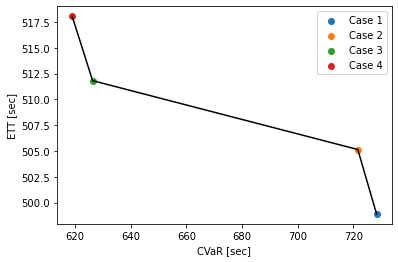

In [32]:
CaseInvestigated["CVaRSolutions"]
tmp=[0,1,10,11]

#Frontier
plt.plot(CaseInvestigated["CVaRSolutions"], CaseInvestigated["ETTSolutions"], c="k")
Colors=list(mcolors.TABLEAU_COLORS.values())+list(mcolors.TABLEAU_COLORS.values())+list(mcolors.TABLEAU_COLORS.values())

for i in range(len(tmp)):
    plt.scatter(CaseInvestigated["CVaRSolutions"][tmp[i]], CaseInvestigated["ETTSolutions"][tmp[i]], c=Colors[i], label="Case "+str(i+1))
plt.legend()


plt.xlabel("CVaR [sec]")
plt.ylabel("ETT [sec]")
plt.show()


## Plot Frontier and Route

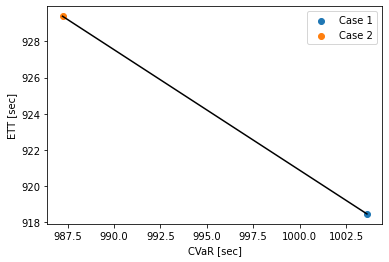

In [39]:
#Frontier
plt.plot(CaseInvestigated["CVaRSolutions"], CaseInvestigated["ETTSolutions"], c="k")
Colors=list(mcolors.TABLEAU_COLORS.values())+list(mcolors.TABLEAU_COLORS.values())+list(mcolors.TABLEAU_COLORS.values())

for i in range(len(CaseInvestigated["ETTSolutions"])):
    plt.scatter(CaseInvestigated["CVaRSolutions"][i], CaseInvestigated["ETTSolutions"][i], c=Colors[i], label="Case "+str(i+1))
plt.legend()


plt.xlabel("CVaR [sec]")
plt.ylabel("ETT [sec]")
plt.show()


100%|██████████| 33278/33278 [00:00<00:00, 678531.73it/s]


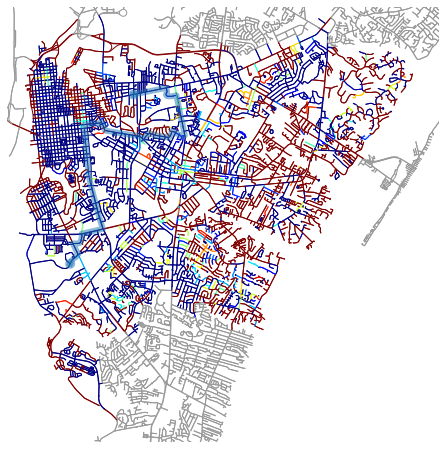

In [40]:
# Single Region (Flood + routes)
from mpl_toolkits.axes_grid1 import make_axes_locatable
RoadNetwork=ox.load_graphml(PathData+"OSM_Wilmington.xml")
Edges=list(RoadNetwork.edges)


for i in tqdm(range(Arc_Idx.shape[0])):
    RoadNetwork.edges[Edges[i]]["C"]=Constant[i]
    

ec_F = ox.plot.get_edge_colors_by_attr(RoadNetwork, 'C',cmap='jet')


#If Not Usefull change color to gray
for i in range(len(ec_F)):
    if Arc_Travel_Time[i,0]==np.inf:
        ec_F[ec_F.keys()[i]]="#999999"


fig, ax = ox.plot_graph(RoadNetwork, node_alpha=0,edge_alpha=None, edge_color=ec_F,dpi=1000, bgcolor = 'white', show=False, bbox=(34.27,34.12,-77.78,-77.96))

for k in range(len(CaseInvestigated["RouteSolutionsID"])):
    ox.plot_graph_route(RoadNetwork, CaseInvestigated["RouteSolutionsID"][k], route_linewidth=6, route_color=Colors[k], node_size=0,ax=ax)
    
cmap = plt.cm.get_cmap('jet') #viridis
norm=plt.Normalize(vmin=np.min(Constant), vmax=np.max(Constant))
sm=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
# cb = fig.colorbar(sm,ax=ax, location = 'right', pad=0.05, fraction=0.04)

shp1 = shp.Reader(PathData+"./Projection/Export_Output.shp")
points=shp1.shape().points
Lat_W=[points[i][1] for i in range(len(points))]
Long_W=[points[i][0] for i in range(len(points))]

ax.plot(Long_W[:-790],Lat_W[:-790],c='k') # City boundaries
ax.plot([Long_W[835],Long_W[2500]],[Lat_W[835],Lat_W[2500]],c='k') # City boundaries
ax.plot([Long_W[1870],Long_W[3810]],[Lat_W[1870],Lat_W[3810]],c='k') # City boundaries
cb = fig.colorbar(sm,ax=ax, location = 'right', pad=0.05, fraction=0.04)
cb.ax.set_title('mm') 


ax.text(-77.79,34.239,"NE", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})
ax.text(-77.834,34.175,"SE", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})
ax.text(-77.97,34.175,"SW", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})
ax.text(-77.97,34.239,"NW", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})

fig.savefig("Route1.png", dpi=1000, bbox_inches='tight')

fig.clf()

100%|██████████| 33278/33278 [00:00<00:00, 678528.43it/s]


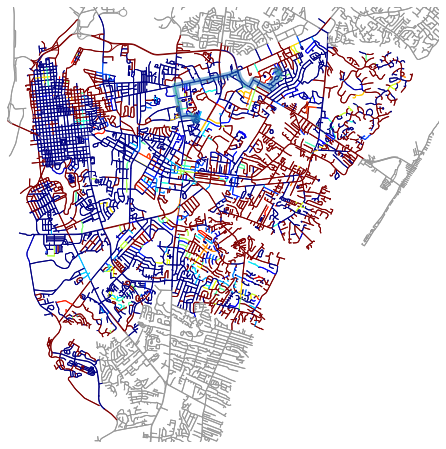

In [33]:
# Single Region (Flood + routes)
from mpl_toolkits.axes_grid1 import make_axes_locatable
RoadNetwork=ox.load_graphml(PathData+"OSM_Wilmington.xml")
Edges=list(RoadNetwork.edges)


for i in tqdm(range(Arc_Idx.shape[0])):
    RoadNetwork.edges[Edges[i]]["C"]=Constant[i]
    

ec_F = ox.plot.get_edge_colors_by_attr(RoadNetwork, 'C',cmap='jet')


#If Not Usefull change color to gray
for i in range(len(ec_F)):
    if Arc_Travel_Time[i,0]==np.inf:
        ec_F[ec_F.keys()[i]]="#999999"


fig, ax = ox.plot_graph(RoadNetwork, node_alpha=0,edge_alpha=None, edge_color=ec_F,dpi=1000, bgcolor = 'white', show=False, bbox=(34.27,34.12,-77.78,-77.96))

for k in range(len(tmp)):
    ox.plot_graph_route(RoadNetwork, CaseInvestigated["RouteSolutionsID"][tmp[k]], route_linewidth=6, route_color=Colors[k], node_size=0,ax=ax)
    
cmap = plt.cm.get_cmap('jet') #viridis
norm=plt.Normalize(vmin=np.min(Constant), vmax=np.max(Constant))
sm=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
# cb = fig.colorbar(sm,ax=ax, location = 'right', pad=0.05, fraction=0.04)

shp1 = shp.Reader(PathData+"./Projection/Export_Output.shp")
points=shp1.shape().points
Lat_W=[points[i][1] for i in range(len(points))]
Long_W=[points[i][0] for i in range(len(points))]

ax.plot(Long_W[:-790],Lat_W[:-790],c='k') # City boundaries
ax.plot([Long_W[835],Long_W[2500]],[Lat_W[835],Lat_W[2500]],c='k') # City boundaries
ax.plot([Long_W[1870],Long_W[3810]],[Lat_W[1870],Lat_W[3810]],c='k') # City boundaries
cb = fig.colorbar(sm,ax=ax, location = 'right', pad=0.05, fraction=0.04)
cb.ax.set_title('mm') 


ax.text(-77.79,34.239,"NE", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})
ax.text(-77.834,34.175,"SE", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})
ax.text(-77.97,34.175,"SW", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})
ax.text(-77.97,34.239,"NW", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})

fig.savefig("Route1.png", dpi=1000, bbox_inches='tight')

fig.clf()

In [357]:
Data=np.load(PathData+"DJKFlorence.npz",allow_pickle=True)
DJKs_Road_V0     =Data["DJKs_Road_Flood"].item()
Arc_Travel_Time  =DJKs_Road_V0["Arc_Travel_Time"]
Arc_Flood        =DJKs_Road_V0["Arc_Flood"]

100%|██████████| 33278/33278 [00:00<00:00, 678528.43it/s]


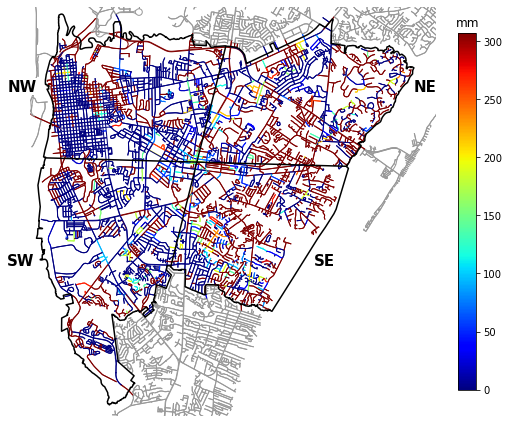

In [12]:

Constant=Arc_Flood[:,-1]
Constant[Constant>307.16]=307.16


# Single Region Flood Only
from mpl_toolkits.axes_grid1 import make_axes_locatable
RoadNetwork=ox.load_graphml(PathData+"OSM_Wilmington.xml")
Edges=list(RoadNetwork.edges)


for i in tqdm(range(Arc_Idx.shape[0])):
    RoadNetwork.edges[Edges[i]]["C"]=Constant[i]
    

ec_F = ox.plot.get_edge_colors_by_attr(RoadNetwork, 'C',cmap='jet')


#If Not Usefull change color to gray
for i in range(len(ec_F)):
    if Arc_Travel_Time[i,0]==np.inf:
        ec_F[ec_F.keys()[i]]="#999999"


fig, ax = ox.plot_graph(RoadNetwork, node_alpha=0,edge_alpha=None, edge_color=ec_F,dpi=1000, bgcolor = 'white', show=False, bbox=(34.27,34.12,-77.78,-77.96))

    
cmap = plt.cm.get_cmap('jet') #viridis
norm=plt.Normalize(vmin=np.min(Constant), vmax=np.max(Constant))
sm=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
# cb = fig.colorbar(sm,ax=ax, location = 'right', pad=0.05, fraction=0.04)

shp1 = shp.Reader(PathData+"./Projection/Export_Output.shp")
points=shp1.shape().points
Lat_W=[points[i][1] for i in range(len(points))]
Long_W=[points[i][0] for i in range(len(points))]

ax.plot(Long_W[:-790],Lat_W[:-790],c='k') # City boundaries
ax.plot([Long_W[835],Long_W[2500]],[Lat_W[835],Lat_W[2500]],c='k') # City boundaries
ax.plot([Long_W[1870],Long_W[3810]],[Lat_W[1870],Lat_W[3810]],c='k') # City boundaries
cb = fig.colorbar(sm,ax=ax, location = 'right', pad=0.05, fraction=0.04)
cb.ax.set_title('mm') 


ax.text(-77.79,34.239,"NE", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})
ax.text(-77.834,34.175,"SE", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})
ax.text(-77.97,34.175,"SW", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})
ax.text(-77.97,34.239,"NW", c="k" ,fontsize=15, weight="bold", bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1})

fig.savefig("FloodRefAVG.png", dpi=600, bbox_inches='tight')